# Import libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Create a class to select numerical or categorical columns
https://www.eventbrite.com/e/virtual-ai-expo-odsc-east-2020-tickets-87295672707
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [4]:
# Metric imports
from sklearn.model_selection import cross_val_score, ShuffleSplit
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# result logs
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [5]:
# p-value metrics function

def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Data import and EDA

In [6]:
data = pd.read_csv('datasets/titanic/train.csv')
y = data['Survived']
x = data.drop(['Survived', 'Ticket', 'Cabin'], axis = 1)

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
# Show the correlation of the Survived column with the features

corr_matrix = data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

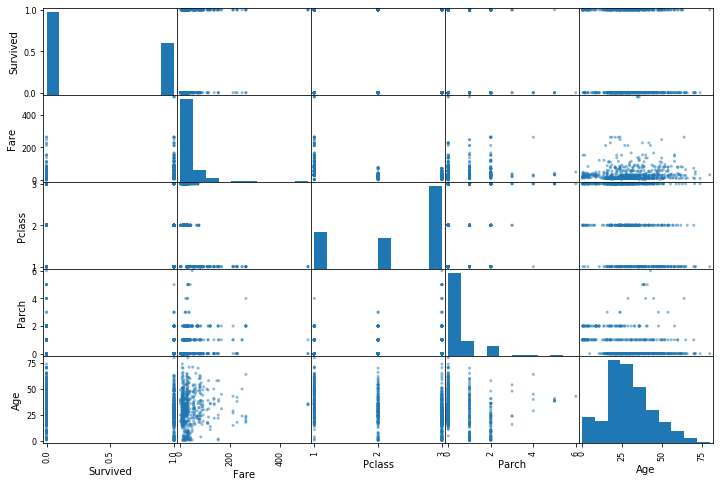

In [11]:
# Scatter matrix of Top four correlated inputs with survived

from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Pclass", "Parch", "Age"]
scatter_matrix(data[attributes], figsize=(12, 8));

## Evaluate categorical features with respect to Survived

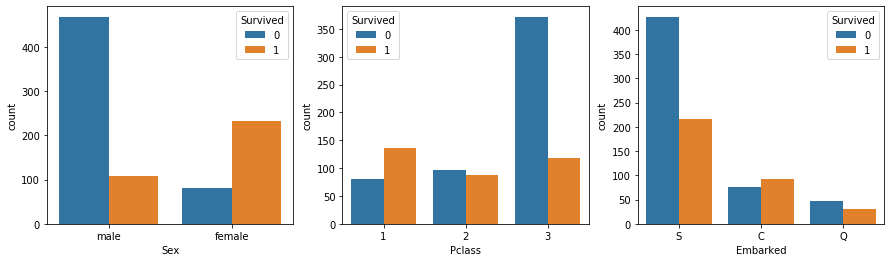

In [12]:
cat_vars = ['Sex', 'Pclass', 'Embarked']
plt.figure(figsize=(15,4))
for idx, cat in enumerate(cat_vars):
    plt.subplot(1, 3, idx+1)
    sns.countplot(data[cat], hue=data['Survived'])

In [13]:
# split data set into test and train

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)               
 

# Build processing pipelines
In this part of the homework the focus is on constructing the pipeline. Since the data has both numerical and categorical features, it is required to create two pipelines (one for each category of data) because they require different transformations. After finishing that, the two pipelines should be unified to produce one full pipeline that performs transformation on all the dataset

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Identify the numeric features we wish to consider. 
num_attribs = [
    'Age', 
    'Parch', 
    'SibSp',
    'Fare'
]
# Create a pipeline for the numeric features.

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])              

# Identify the categorical features to consider.
cat_attribs = [
    "Embarked", 
    "Sex",
    "Pclass"
]
# Identiy the range of expected values for categorical features.
cat_values = [
    ['S','C','Q'],     
    ['female','male'],
    [1,2,3] 
]

# Create a pipelne for the categorical features.
# one hot encoding used
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# Joining the scaled numeric and categorical features.

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])                 


## New feature based on the title from each passengers name

### Evaluate the distribution of titles

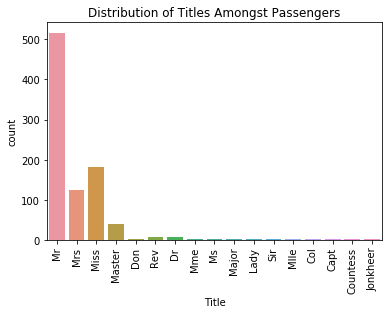

In [18]:
data['Title'] = data['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data)
plt.title('Distribution of Titles Amongst Passengers')
plt.xticks(rotation=90);

### Consolidate special and miscellaneous titles
Most titles fall into one of four categories (Mr, Mrs., Miss, Master).  All other titles can be combined with one of these groups (i.e., they are French varients) or grouped as "other". 

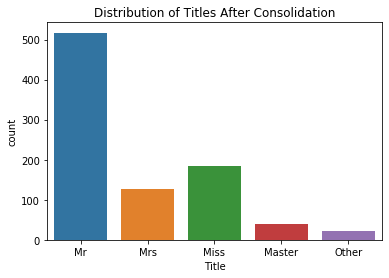

In [19]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir', 
                                       'Col', 'Capt', 'Countess', 'Jonkheer'],'Other')
sns.countplot(x='Title', data=data);
plt.title('Distribution of Titles After Consolidation');

## Create a transformer to perfom this new feature transformation in a pipeline

In [20]:
class TitleAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.features)
        df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        # Apply the necessary transformations to obtain the 5 title categories
        # (Mr, Mrs, Miss, Master, Other) like it was done in section 5.1.2
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
        df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir', 
                                       'Col', 'Capt', 'Countess', 'Jonkheer'],'Other')                
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#
        df.drop('Name', axis=1, inplace=True)
        return np.array(df.values)

# Modeling

## Baseline Logistic Regression

In [23]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LogisticRegression())
    ])

# split data with 20% test data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

In [24]:
start = time()
full_pipeline_with_predictor.fit(x_train, y_train)
np.random.seed(42)

# Set up cross validation scores using ShuffleSplit() with 30 splits, 30% test_size 

cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train, cv=cv30Splits)             

logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [25]:
results.loc[0] = ["Baseline", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,79.6,79.9,---,1.169,0.0081,Untuned LogisticRegression


## Conduct Grid Search using a variety of Classification Algorithms

In [26]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(x_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv30Splits)
        best_train_accuracy = pct(np.mean(best_train_scores))       
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [ ]:
%%time

# Main function
if __name__ == "__main__":
    ConductGridSearch(x_train, y_train, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished


Best Parameters:
	predictor__C: 0.1
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.8s finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.7s finished


Best Parameters:
	predictor__C: 10
	predictor__degree: 2
	predictor__kernel: poly
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   18.1s finished


Best Parameters:
	predictor__alpha: 0.01
	predictor__loss: log
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
results

## Observations

* The Support Vector Classifier with parameters [C=1, degree=1, kernel=rbf] had the best overall performance  by the Random Forest classifier. The p-values of 0.000 and 0001, respectively, indicate that both results are signficantly different from the baseline Logistic Regression model. 
* There tuned Logistic Regression was not statistically different than the baseline (untuned) model.